IMPORTS

In [31]:
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display_functions import display
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
import imblearn
from imblearn.over_sampling import SMOTE

# Load the data
dados = pd.read_csv('./dataset.csv')

# Sample data
dados.sample(10)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
233,33,Male,2.0,1.4,2110,48,89,6.2,3.0,0.90,1
175,31,Male,0.8,0.2,198,43,31,7.3,4.0,1.20,1
27,34,Male,6.2,3.0,240,1680,850,7.2,4.0,1.20,1
362,55,Male,1.1,0.3,215,21,15,6.2,2.9,0.80,2
531,40,Male,30.8,18.3,285,110,186,7.9,2.7,0.50,1
73,52,Male,0.6,0.1,171,22,16,6.6,3.6,1.20,1
132,18,Female,0.8,0.2,199,34,31,6.5,3.5,1.16,2
243,28,Female,0.9,0.2,316,25,23,8.5,5.5,1.80,1
260,42,Male,16.4,8.9,245,56,87,5.4,2.0,0.50,1
402,42,Female,0.5,0.1,162,155,108,8.1,4.0,0.90,1





EXPLORATORY DATA ANALYSIS

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object
Gender    object
dtype: object
Age                             int64
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object


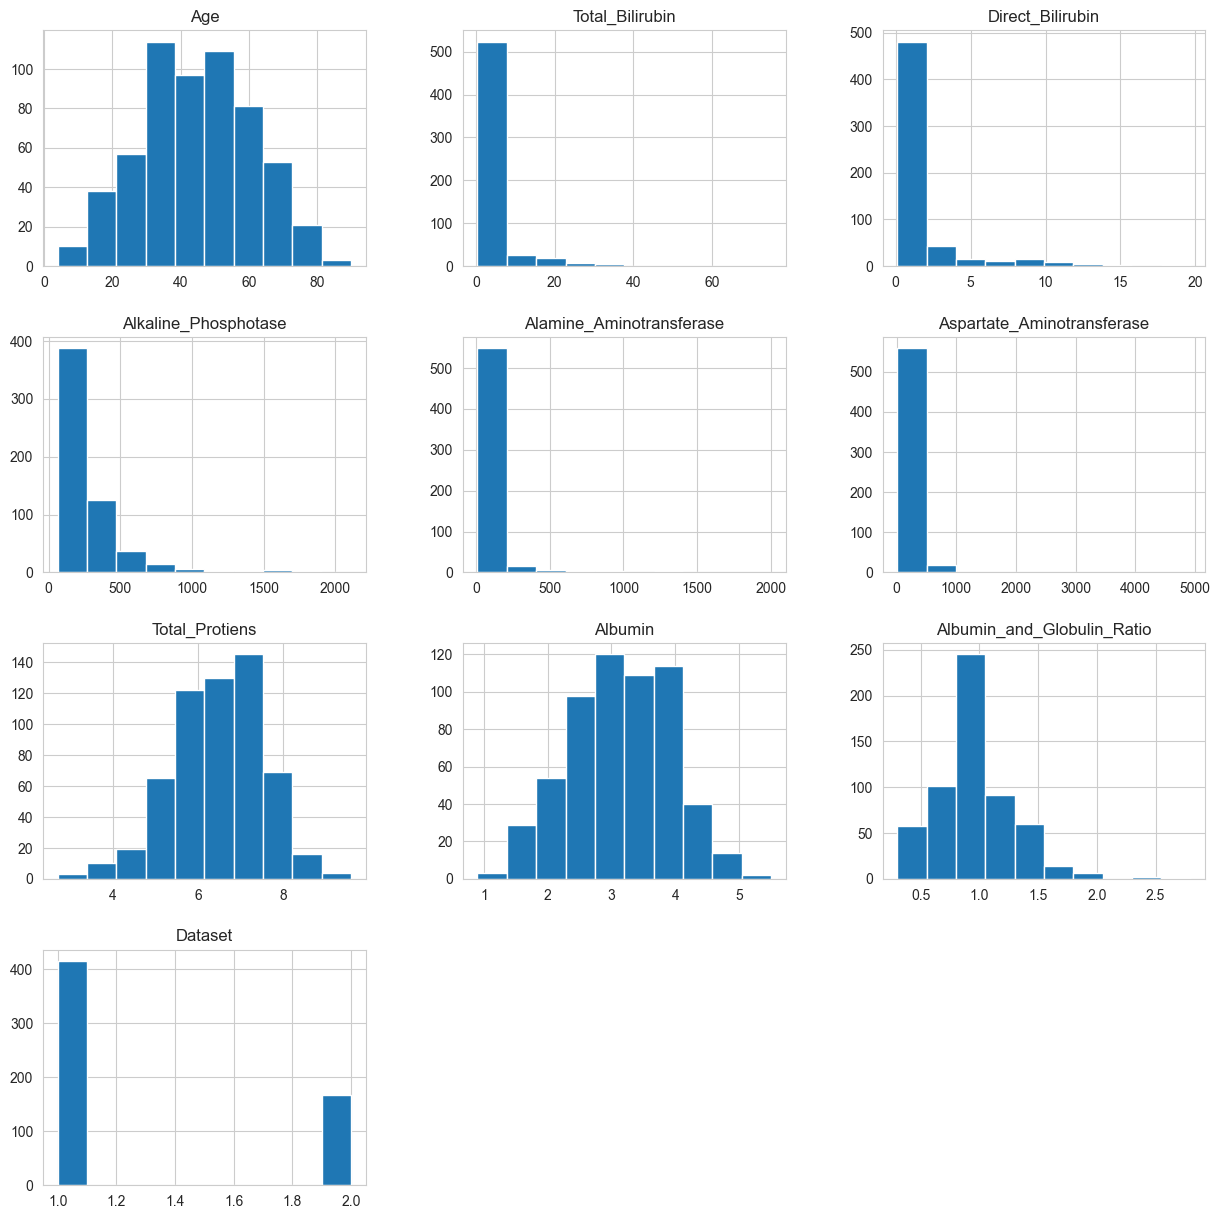

In [32]:
# Data types
print(dados.dtypes)

# Categorical variables
print(dados.dtypes[dados.dtypes == 'object'])

# Non-categorical variables
print(dados.dtypes[dados.dtypes != 'object'])

# Exploration of Numerical Variables
dados.describe()

# Plot 
dados.hist(figsize = (15, 15), bins = 10)
plt.show()

# Apparently there is an outlier in the variables "Alamine_Aminotransferase" and "Aspartate_Aminotransferase"
# Due to the fact that the maximum value is much higher than the average value.
# The dataset column (target variable) has '1' for liver disease and '2' for no liver disease.
# Let's adjust the variable by putting values that are easier to interpret. The negative class (does not have the disease) will be zero.

# Function to adjust target variable
def ajusta_var(x):
    if x == 2:
        return 0
    return 1

# Apply the function
dados['Dataset'] = dados['Dataset'].map(ajusta_var)

# Let's adjust the target variable name
dados.rename({'Dataset':'Target'}, axis = 'columns', inplace = True)


ATTRIBUTE ENGINEERING

Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Target'],
      dtype='object')
                                 Age  Total_Bilirubin  Direct_Bilirubin  \
Age                         1.000000         0.011763          0.007529   
Total_Bilirubin             0.011763         1.000000          0.874618   
Direct_Bilirubin            0.007529         0.874618          1.000000   
Alkaline_Phosphotase        0.080425         0.206669          0.234939   
Alamine_Aminotransferase   -0.086883         0.214065          0.233894   
Aspartate_Aminotransferase -0.019910         0.237831          0.257544   
Total_Protiens             -0.187461        -0.008099         -0.000139   
Albumin                    -0.265924        -0.222250         -0.228531   
Albumin_and_Globulin_Ratio -0.216408        -0.206267         -0.200125   
Target   

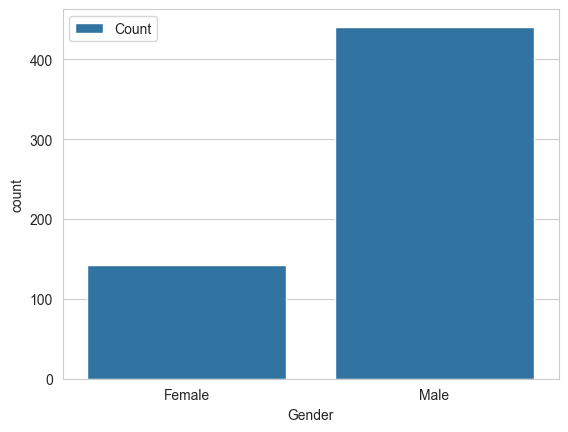

In [33]:
# Select only numeric columns
dados_numeric = dados.select_dtypes(include=['float64', 'int64'])

# Print the columns
print(dados_numeric.columns)

# Correlation between variables
correlation_matrix = dados_numeric.corr()

# Print the correlation matrix
print(correlation_matrix)

# Exploration of the Categorical Variable
dados.describe(include = ['object'])

# Plot
sns.countplot(data = dados, x = 'Gender', label = 'Count')

# Value counts
M, F = dados['Gender'].value_counts()

# Print
print('Number of male patients: ', M)
print('Number of female patients: ', F)



     Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
209   45       1              0.9               0.3                   189   
241   51       0              0.8               0.2                   230   
253   35       1              0.6               0.2                   180   
312   27       0              1.3               0.6                   106   

     Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
209                        23                          33             6.6   
241                        24                          46             6.5   
253                        12                          15             5.2   
312                        25                          54             8.5   

     Albumin  Albumin_and_Globulin_Ratio  Target  
209      3.9                         NaN       1  
241      3.1                         NaN       1  
253      2.7                         NaN       0  
312      4.8            

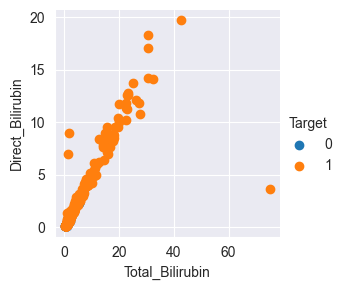

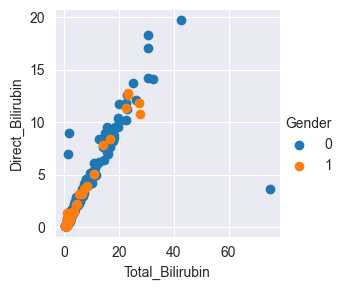

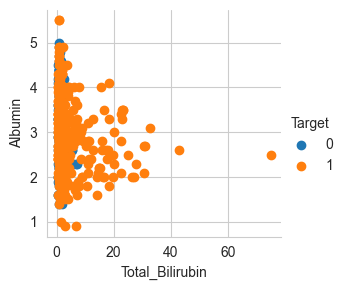

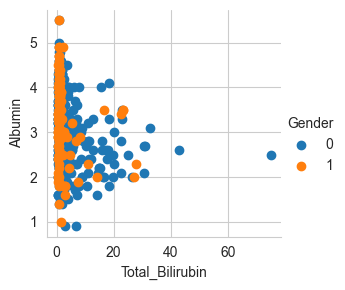

In [34]:
# Let's take advantage of this and transform the categorical variable into its numeric representation using label encoding.
# In addition to reducing work later, it will make it easier to create charts to follow.
# Function for label encoding
def encoding_func(x):
    if x == 'Male':
        return 0
    return 1

# Apply the function
dados['Gender'] = dados['Gender'].map(encoding_func)
dados.sample(5)

# Checking the Relationship Between Attributes
dados.corr()

# Set the background style
sns.set_style('darkgrid')  

# Facetgrid
sns.FacetGrid(dados, hue = 'Target').map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend()

# Set the background style
sns.set_style('darkgrid')  

# Facetgrid
sns.FacetGrid(dados, hue = 'Gender').map(plt.scatter, 'Total_Bilirubin', 'Direct_Bilirubin').add_legend()

# Set the background style
sns.set_style('whitegrid') 

# Facetgrid
sns.FacetGrid(dados, hue = 'Target').map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend()

# Set the background style
sns.set_style('whitegrid') 

# Facetgrid
sns.FacetGrid(dados, hue = 'Gender').map(plt.scatter, 'Total_Bilirubin', 'Albumin').add_legend()

# Checking for Missing Values and Duplicate Records
# Checking for missing values
print(dados[dados.isnull().values])

# Checking for duplicate records (complete cases)
# Complete cases also refer to lines where there are no missing values
print(dados[dados.duplicated(keep = False)])

(583, 11)
(570, 11)
     Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
209   45       1              0.9               0.3                   189   
241   51       0              0.8               0.2                   230   
253   35       1              0.6               0.2                   180   
312   27       0              1.3               0.6                   106   

     Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
209                        23                          33             6.6   
241                        24                          46             6.5   
253                        12                          15             5.2   
312                        25                          54             8.5   

     Albumin  Albumin_and_Globulin_Ratio  Target  
209      3.9                         NaN       1  
241      3.1                         NaN       1  
253      2.7                         NaN       0  
312 

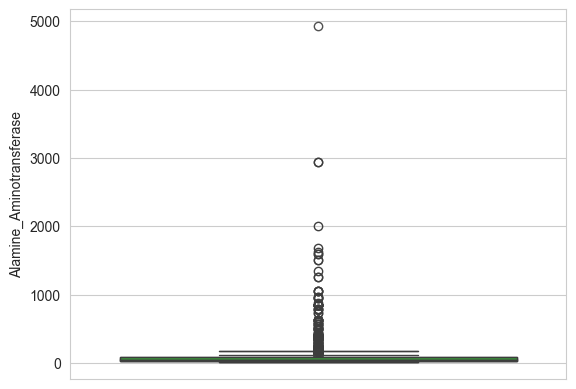

In [35]:
# Handling Duplicate Records
print(dados.shape)

# Remove duplicate records (remove one of the duplicates)
dados = dados.drop_duplicates()
print(dados.shape)

# Handling Outliers
dados.describe()

# Boxplot
sns.boxplot(dados.Alamine_Aminotransferase)

# Are the extreme values really outliers? Frequency count by value
dados.Alamine_Aminotransferase.sort_values(ascending = False).head()

# Boxplot
sns.boxplot(dados.Aspartate_Aminotransferase)

# Frequency count by value
dados.Aspartate_Aminotransferase.sort_values(ascending = False).head()

# Keep only records where the value is less than or equal to 3000
dados = dados[dados.Aspartate_Aminotransferase <= 3000]

# Boxplot
sns.boxplot(dados.Aspartate_Aminotransferase)

# Frequency count by value
dados.Aspartate_Aminotransferase.sort_values(ascending = False).head()

# Keep only records where the value is less than or equal to 2500
dados = dados[dados.Aspartate_Aminotransferase <= 2500]
dados.describe()

# Handling Missing Values. Check for missing value
dados.isnull().values.any()

# Check how many columns have missing value
dados.isnull().values.any().sum()

# List missing values
print(dados[dados.isnull().values])

# Drop records with missing values in any column (any)
dados = dados.dropna(how = 'any')  

# List missing values
print(dados[dados.isnull().values])

PRE-PROCESSING DATA

In [36]:
# Given the high correlation between variables Direct_Bilirubin and Total_Bilirubin, let's remove Direct_Bilirubin
dados = dados.drop('Direct_Bilirubin', axis=1)

# Split into Training and Test
dados.head()

# Create a separate object for the target variable
y = dados.Target

# Create a separate object for input variables
X = dados.drop('Target', axis = 1)

# Split into training and test data with stratified sampling
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y,
test_size = 0.25, random_state = 1234, stratify = dados.Target)
len(X_treino)
len(X_teste)

# Print do shape
print(X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape)
X_treino.head(2)

# Class Balancing
# As it stands, we have a lot more information about the variable target(1) than the variable(0)
# With this, we will be giving the model many more examples of the first class than the second class
# Making it learn much more about a class than about another, generating a biased model.
y_treino.value_counts()

# A first strategy would be to reduce the majority class records by removing some records from Class 1
# This strategy can greatly reduce the size of the dataframe, thus having fewer examples to train the model
# Another strategy would be the technique of oversampling and increasing the number of examples of the minority class
# In order to detect the pattern of the records of the class (0), and create synthetic data with the same pattern.
# Increasing with this the amount of lines of the minority class.
over_sampler = SMOTE(k_neighbors = 2)

# Explain why class balancing is done with training data only.
# Apply oversampling (should only be done with training data)
X_res, y_res = over_sampler.fit_resample(X_treino, y_treino)
len(X_res)
len(y_res)
y_res.value_counts()

# Set the training dataset name to X
X_treino = X_res

# Set the training dataset name to y
y_treino = y_res

# Data standardization
# The goal is to resize the variables so that they have properties of
# A normal distribution with mean equal to zero and standard deviation equal to one.
X_treino.head()

# Calculate mean and standard deviation of training data
treino_mean = X_treino.mean()
treino_std = X_treino.std()
print(treino_mean)
print(treino_std)

# Standardization
X_treino = (X_treino - treino_mean) / treino_std
X_treino.head()
X_treino.describe()

# We use training mean and deviation to standardize the test dataset
X_teste = (X_teste - treino_mean) / treino_std
X_teste.head()


(423, 9) (141, 9) (423,) (141,)
Age                            43.908638
Gender                          0.207641
Total_Bilirubin                 2.664010
Alkaline_Phosphotase          268.920266
Alamine_Aminotransferase       62.338870
Aspartate_Aminotransferase     77.279070
Total_Protiens                  6.519374
Albumin                         3.243041
Albumin_and_Globulin_Ratio      0.999619
dtype: float64
Age                            16.428941
Gender                          0.405956
Total_Bilirubin                 5.568674
Alkaline_Phosphotase          223.696826
Alamine_Aminotransferase      139.931983
Aspartate_Aminotransferase    144.201209
Total_Protiens                  1.023683
Albumin                         0.767759
Albumin_and_Globulin_Ratio      0.312638
dtype: float64


,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
220,-0.420516,-0.511487,-0.334732,-0.545025,-0.252543,-0.216913,-1.484224,-0.967806,0.001218
448,0.249034,1.951835,-0.334732,-0.567376,-0.259690,-0.362543,-0.507358,-0.837557,-0.958358
509,0.127297,-0.511487,3.113127,-0.066699,0.554992,3.208856,-1.093478,-0.316560,0.640936
415,1.588134,-0.511487,-0.244944,1.882368,0.219115,-0.258521,-2.851835,-0.707307,-0.958358
56,-0.663989,-0.511487,-0.334732,-0.317037,-0.259690,-0.376412,1.446372,0.985933,0.001218


MODEL 1: LOGISTIC REGRESSION (BENCHMARK)

In [37]:
# For the first version of the model, the ideal is to choose a simple and easy-to-understand algorithm.
# As part of the process involves randomness, the results may be slightly different each run.
# Define list of hyperparameters
tuned_params_v1 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'penalty': ['l1', 'l2']}

# We will create the model with GridSearch
# Several models will be created with different combinations of hyperparameters
modelo_v1 = GridSearchCV(LogisticRegression(), tuned_params_v1, scoring = 'roc_auc', n_jobs = -1)

# Model training
modelo_v1.fit(X_treino, y_treino)

# Select the best model
print(modelo_v1.best_estimator_)

# Predictions with test data
y_pred_v1 = modelo_v1.predict(X_teste)

# Show the first 10 predictions
# This algorithm shows both the classes as well as the probability.
print(y_pred_v1[:10])

# Get predictions in probability format for each class
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)

# Show the first 10 predictions
print(y_pred_proba_v1[:10])

# Get the predictions in probability format by filtering for the positive class
# Need this to calculate the ROC Curve
y_pred_proba_v1 = modelo_v1.predict_proba(X_teste)[:,1]

# Show the first 10 predictions
print(y_pred_proba_v1[:10])

# As an example, let's check one of the data points (change the value of i if you wish)
# For data point 16, actual class=1, predicted class=0, predicted probability = 0.463
i = 16
print('for the data point {}, real class = {}, expected class = {}, predicted probability = {}'.
      format(i, y_teste.iloc[i], y_pred_v1[i], y_pred_proba_v1[i]))

# Confusion matrix
confusion_matrix(y_teste, y_pred_v1)

# Extracting each value from the CM
tn, fp, fn, tp = confusion_matrix(y_teste, y_pred_v1).ravel()
print(tn, fp, fn, tp)

# Calculates the global metric AUC (Area Under The Curve) with real data and test predictions
roc_auc_v1 = roc_auc_score(y_teste, y_pred_v1)
print(roc_auc_v1)

# Calculate the ROC curve with test data and predictions
fpr_v1, tpr_v1, thresholds = roc_curve(y_teste, y_pred_proba_v1)

# AUC test
auc_v1 = auc(fpr_v1, tpr_v1)
print(auc_v1)

# Accuracy test
acuracia_v1 = accuracy_score(y_teste, y_pred_v1)
print(acuracia_v1)

# Feature Importance
# Building the model again with the best hyperparameters
# This is necessary as the final version must not have GridSearchCV
modelo_v1 = LogisticRegression(C = 1)
modelo_v1.fit(X_treino, y_treino)

# Get the coefficients by greatest using np.argsort
indices = np.argsort(-abs(modelo_v1.coef_[0, :]))
print("Most important variables for the result of model_v1: ")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

# Save the model to disk
with open('modelos/modelo_v1.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v2, 'modelos/modelo_v1.pkl') 

# Dictionary with model_v1 metrics
dict_modelo_v1 = pd.Series({'Name': 'model_v1', 'Algorithm': 'Logistic Regression',
'ROC_AUC Score': roc_auc_v1, 'AUC Score': auc_v1, 'Accuracy': acuracia_v1})

display(dict_modelo_v1)

LogisticRegression(C=1)
[0 1 1 0 0 0 0 1 0 1]
[[7.50284298e-01 2.49715702e-01]
 [4.82275457e-01 5.17724543e-01]
 [6.80780190e-05 9.99931922e-01]
 [6.39250950e-01 3.60749050e-01]
 [6.60063641e-01 3.39936359e-01]
 [6.08822678e-01 3.91177322e-01]
 [7.45310205e-01 2.54689795e-01]
 [8.87411507e-02 9.11258849e-01]
 [6.09463000e-01 3.90537000e-01]
 [7.02419638e-03 9.92975804e-01]]
[0.2497157  0.51772454 0.99993192 0.36074905 0.33993636 0.39117732
 0.25468979 0.91125885 0.390537   0.9929758 ]
for the data point 16, real class = 1, expected class = 1, predicted probability = 0.648765400540576
30 10 38 63
0.6868811881188119
0.7254950495049505
0.6595744680851063
Most important variables for the result of model_v1: 
--------------------------------------------------
Total_Bilirubin
Aspartate_Aminotransferase
Alamine_Aminotransferase
Total_Protiens
Albumin
Age
Gender
Alkaline_Phosphotase
Albumin_and_Globulin_Ratio


C:\Users\Puneet\Downloads\Project-11-main\Project-11-main\liver\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Puneet\Downloads\Project-11-main\Project-11-main\liver\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Puneet\Downloads\Project-11-main\Project-11-main\liver\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Puneet\Downloads\Project-11-main\Pr

Name                        model_v1
Algorithm        Logistic Regression
ROC_AUC Score               0.686881
AUC Score                   0.725495
Accuracy                    0.659574
dtype: object

MODEL 2: RANDOM FOREST

In [38]:
# Our challenge now is to try to get a better model than version 1. Let's try the Random Forest algorithm.
# Hyperparameter grid
tuned_params_v2 = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

# Create the model with RandomizedSearchCV to search for the best combination of hyperparameters
modelo_v2 = RandomizedSearchCV(RandomForestClassifier(), tuned_params_v2, n_iter = 15, scoring = 'roc_auc', n_jobs = -1)

# Train the model
modelo_v2.fit(X_treino, y_treino)

# Extract the best model
print(modelo_v2.best_estimator_)

# Forecasts test
y_pred_v2 = modelo_v2.predict(X_teste)

# Get predictions for the positive class
y_pred_proba_v2 = modelo_v2.predict_proba(X_teste)[:,1]

# Confusion Matrix
confusion_matrix(y_teste, y_pred_v2)

# ROC curve on test data and predictions
roc_auc_v2 = roc_auc_score(y_teste, y_pred_v2)
print(roc_auc_v2)

# ROC curve on test data and predictions
fpr_v2, tpr_v2, thresholds = roc_curve(y_teste, y_pred_proba_v2)

# AUC test
auc_v2 = auc(fpr_v2, tpr_v2)
print(auc_v2)

# Accuracy test
acuracia_v2 = accuracy_score(y_teste, y_pred_v2)
print(acuracia_v2)

# Feature Importance
# Recreate the model with the best hyperparameters
modelo_v2 = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 4)
modelo_v2.fit(X_treino, y_treino)

# Most relevant variables
indices = np.argsort(-modelo_v2.feature_importances_)
print("Most important variables for the v2_model result:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

# Save the model to disk
with open('modelos/modelo_v2.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v2, 'modelos/modelo_v2.pkl') 

# Dictionary with model_v2 metrics
dict_modelo_v2 = {'Name': 'model_v2', 'Algorithm': 'Random Forest', 'ROC_AUC Score': roc_auc_v2,
'AUC Score': auc_v2, 'Accuracy': acuracia_v2}

display(dict_modelo_v2)

RandomForestClassifier(n_estimators=500)
0.6408415841584157
0.7538366336633664
0.723404255319149
Most important variables for the v2_model result:
--------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Aspartate_Aminotransferase
Alamine_Aminotransferase
Albumin_and_Globulin_Ratio
Age
Total_Protiens
Albumin
Gender


{'Name': 'model_v2',
 'Algorithm': 'Random Forest',
 'ROC_AUC Score': 0.6408415841584157,
 'AUC Score': 0.7538366336633664,
 'Accuracy': 0.723404255319149}

MODEL 3: KNN

In [39]:
# Let's now try a simpler algorithm, KNN. For this algorithm, we first need
# define the value of K, which is the number of nearest neighbors.
# List of possible values of K
vizinhos = list(range(1, 20, 2))

# List for scores
cv_scores = []

# Cross-validation to determine the best value of k
for k in vizinhos:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_treino, y_treino, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())   

# Adjusting the sort error
erro = [1 - x for x in cv_scores]

# Determining the best value of k (with the smallest error)
optimal_k = vizinhos[erro.index(min(erro))]
print('The ideal value of k is %d' % optimal_k)

# We create the model version 3
modelo_v3 = KNeighborsClassifier(n_neighbors = optimal_k)

# Training
modelo_v3.fit(X_treino, y_treino)

# Forecasts
y_pred_v3 = modelo_v3.predict(X_teste)

# Confusion Matrix
confusion_matrix(y_teste, y_pred_v3)

# Positive class probability prediction
y_pred_proba_v3 = modelo_v3.predict_proba(X_teste)[:, 1]

# Calculate ROC_AUC test
roc_auc_v3 = roc_auc_score(y_teste, y_pred_v3)
print(roc_auc_v3)

# Calculate ROC curve
fpr_v3, tpr_v3, thresholds = roc_curve(y_teste, y_pred_proba_v3)

# Calculate AUC on test
auc_v3 = auc(fpr_v3, tpr_v3)
print(auc_v3)

# Calculate Accuracy
acuracia_v3 = accuracy_score(y_teste, y_pred_v3)
print(acuracia_v3)

# Note: With the KNN algorithm we do not extract the most important variables, because the concept of the algorithm is different.
# Save the model to disk
with open('modelos/modelo_v3.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v3, 'modelos/modelo_v3.pkl')

# Dictionary with model_v3 metrics
dict_modelo_v3 = {'Name': 'model_v3', 'Algorithm': 'KNN', 'ROC_AUC Score': roc_auc_v3,
'AUC Score': auc_v3, 'Accuracy': acuracia_v3}

display(dict_modelo_v3)

The ideal value of k is 1
0.5342821782178219
0.5342821782178219
0.5815602836879432


{'Name': 'model_v3',
 'Algorithm': 'KNN',
 'ROC_AUC Score': 0.5342821782178219,
 'AUC Score': 0.5342821782178219,
 'Accuracy': 0.5815602836879432}

MODEL 4: DECISION TREE

In [40]:
# In version 4 of the model we will use a decision tree model.
# hyperparameters
tuned_params_v4 = {'min_samples_split': [2, 3, 4, 5, 7], 'min_samples_leaf': [1, 2, 3, 4, 6],
'max_depth': [2, 3, 4, 5, 6, 7]}

# Create the model with RandomizedSearchCV
modelo_v4 = RandomizedSearchCV(DecisionTreeClassifier(), tuned_params_v4, n_iter = 15, scoring = 'roc_auc', n_jobs = -1)

# Training
modelo_v4.fit(X_treino, y_treino)

# Best Model
print(modelo_v4.best_estimator_)

# Class Predictions
y_pred_v4 = modelo_v4.predict(X_teste)

# Probability Predictions
y_pred_proba_v4 = modelo_v4.predict_proba(X_teste)[:,1]

# confusion Matrix
confusion_matrix(y_teste, y_pred_v4)

# Calculate ROC AUC score
roc_auc_v4 = roc_auc_score(y_teste, y_pred_v4)
print(roc_auc_v4)

# ROC curve
fpr_v4, tpr_v4, thresholds = roc_curve(y_teste, y_pred_proba_v4)

# Calculate AUC
auc_v4 = auc(fpr_v4, tpr_v4)
print(auc_v4)

# Calculate Accuracy
acuracia_v4 = accuracy_score(y_teste, y_pred_v4)
print(acuracia_v4)

# Feature Importance
# Recreating the model
modelo_v4 = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 6, max_depth = 4)
modelo_v4.fit(X_treino, y_treino)

# Most important variables
indices = np.argsort(-modelo_v4.feature_importances_)
print("Most important variables for the v4_model result:")
print(50*'-')
for feature in X.columns[indices]:
    print(feature)

# Save the model to disk
with open('modelos/modelo_v4.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v4, 'modelos/modelo_v4.pkl') 

# Dictionary with model_v4 metrics
dict_modelo_v4 = {'Name': 'model_v4', 'Algorithm': 'Decision Tree', 'ROC_AUC Score': roc_auc_v4, 'AUC Score': auc_v4,
'Accuracy': acuracia_v4}

display(dict_modelo_v4)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)
0.6392326732673268
0.6903465346534654
0.6453900709219859
Most important variables for the v4_model result:
--------------------------------------------------
Total_Bilirubin
Alkaline_Phosphotase
Aspartate_Aminotransferase
Alamine_Aminotransferase
Age
Albumin_and_Globulin_Ratio
Gender
Total_Protiens
Albumin


{'Name': 'model_v4',
 'Algorithm': 'Decision Tree',
 'ROC_AUC Score': 0.6392326732673268,
 'AUC Score': 0.6903465346534654,
 'Accuracy': 0.6453900709219859}

MODEL 5: SVM

In [41]:
# For the fifth and final version of the model we will use SVM.
# Function to select hyperparameters
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel = 'rbf'), param_grid, cv = nfolds)
    grid_search.fit(X_treino, y_treino)
    grid_search.best_params_
    return grid_search.best_params_

# Apply the function
svc_param_selection(X_treino, y_treino, 5)

# Create the model with the best hyperparameters
modelo_v5 = SVC(C = 1, gamma = 1, probability = True)

# Training
modelo_v5.fit(X_treino, y_treino)

# Class predictions
y_pred_v5 = modelo_v5.predict(X_teste)
confusion_matrix(y_teste, y_pred_v5)

# Probability predictions
y_pred_proba_v5 = modelo_v5.predict_proba(X_teste)[:, 1]

# Calculate ROC AUC score
roc_auc_v5 = roc_auc_score(y_teste, y_pred_v5)
print(roc_auc_v5)

# Calculate ROC curve
fpr_v5, tpr_v5, thresholds = roc_curve(y_teste, y_pred_proba_v5)

# Calculate AUC score
auc_v5 = auc(fpr_v5, tpr_v5)
print(auc_v5)

# Calculate Accuracy
acuracia_v5 = accuracy_score(y_teste, y_pred_v5)
print(acuracia_v5)

# Save the model to disk
with open('modelos/modelo_v5.pkl', 'wb') as pickle_file:
      joblib.dump(modelo_v5, 'modelos/modelo_v5.pkl') 

# Dictionary with model_v5 metrics
dict_modelo_v5 = {'Name': 'model_v5', 'Algorithm': 'SVM', 'ROC_AUC Score': roc_auc_v5,
'AUC Score': auc_v5,'Accuracy': acuracia_v5}

display(dict_modelo_v5)

0.5340346534653465
0.6173267326732673
0.6028368794326241


{'Name': 'model_v5',
 'Algorithm': 'SVM',
 'ROC_AUC Score': 0.5340346534653465,
 'AUC Score': 0.6173267326732673,
 'Accuracy': 0.6028368794326241}

Running Model

In [42]:
# Load the best model from disk
melhor_modelo = joblib.load('modelos/modelo_v2.pkl')

# Raw data of a new patient
# The number of columns must be the same as used in training
novo_paciente = [72, 1, 0.8, 186, 15, 29, 7.1, 3.4, 0.97]
                #'Age', 'Gender' (0-F, 1-M), 'Total_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'

# Convert object to array
arr_paciente = np.array(novo_paciente)

# We use training mean and deviation to standardize new data
arr_paciente = (arr_paciente - treino_mean) / treino_std

# Convert object to array
arr_paciente = np.array(arr_paciente)

# Standardized patient data (exactly how the model expects to receive the data)
print(arr_paciente)

# Class predictions
pred_novo_paciente = melhor_modelo.predict(arr_paciente.reshape(1, -1))

# Check the value and print the final result
if pred_novo_paciente == 1:
    print('This patient must have liver disease!')
else:
    print('This patient must not have liver disease!')

[ 1.70987052  1.95183532 -0.3347315  -0.37068146 -0.33829915 -0.3348035
  0.56719356  0.20443755 -0.09473945]
This patient must have liver disease!


C:\Users\Puneet\Downloads\Project-11-main\Project-11-main\liver\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
